# Estimating effective population size from the temporal change in allele frequences (TCAF)

### Isabelle Rajendiran

### 0. Importing packages

In [7]:
# INSTALLING AND IMPORTING PACKAGES

#!pip install scikit-allel
#!pip install -q malariagen_data

import pandas as pd
import numpy as np
import dask
import dask.array as da
from dask.diagnostics.progress import ProgressBar
# silence some warnings
dask.config.set(**{'array.slicing.split_large_chunks': False})
import allel; print('scikit-allel', allel.__version__)
import malariagen_data
import pickle as pickle
import matplotlib.pyplot as plt

scikit-allel 1.3.5


In [8]:
# IMPORT API
# AG3 DATA ACCESS FROM GOOGLE CLOUD

ag3 = malariagen_data.Ag3(pre='True') # Pre=True is needed to include all data from 3.0 release/phase (3.0-3.8)
ag3

<MalariaGEN Ag3 API client>
Storage URL             : gs://vo_agam_release/
Data releases available : 3.0, 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8
Results cache           : None
Cohorts analysis        : 20230223
Species analysis        : aim_20220528
Site filters analysis   : dt_20200416
Software version        : malariagen_data 7.3.1
Client location         : England, GB
---
Please note that data are subject to terms of use,
for more information see https://www.malariagen.net/data
or contact data@malariagen.net. For API documentation see 
https://malariagen.github.io/vector-data/ag3/api.html

### 1.0 Filtering SNPs

The aim is to download the SNPs for Niono, Mali 2013 and 2015 and filter for the intergenic and 4-fold (the force of selection is low on these SNPs) and biallelic SNPs.

Niono 2013 has 73 samples, and 104 for 2015

#### 1.1 Obtaining the metadata

In [ ]:
# LOADING THE METADATA

# Display only the top 10 rows
pd.set_option('display.max_rows', 10)

# Selecting for Niono 2013
Mali_Niono_2013_metadata = ag3.sample_metadata(sample_sets=['1177-VO-ML-LEHMANN-VMF00004','1177-VO-ML-LEHMANN-VMF00015','1191-VO-MULTI-OLOUGHLIN-VMF00106', 'AG1000G-GN-B','AG1000G-ML-A' ],
                                   sample_query = "(country == 'Mali') and (taxon == 'coluzzii') and (year == 2013) and (location == 'Sokourani (Niono)')").set_index("sample_id")

print(len(Mali_Niono_2013_metadata)) # Has 73 rows which matches expected number of samples
      
# Selecting for Niono 2015
      
Mali_Niono_2015_metadata = ag3.sample_metadata(sample_sets=['1177-VO-ML-LEHMANN-VMF00004','1177-VO-ML-LEHMANN-VMF00015','1191-VO-MULTI-OLOUGHLIN-VMF00106', 'AG1000G-GN-B','AG1000G-ML-A' ],
                                   sample_query = "(country == 'Mali') and (taxon == 'coluzzii') and (year == 2015) and (location == 'Sokourani (Niono)')").set_index("sample_id")

print(len(Mali_Niono_2015_metadata)) # Has 104 rows which matches expected number of samples


#### 1.2 Downloading the SNPs

The snp_calls() function also allows the user to select for site_class e.g., intergenic, the region of interest e.g., 3R chromosome, and apply a quality filter (site_mask). Here, the "gamb_colu" filter is used as it's the best for coluzzii species to obtain reliable SNPs.

In [ ]:
# OBTAINING THE INTERGENIC AND 4-FOLD SNPS FOR THE 3R AND X REGION FOR 2013

# Selecting the relevant samples
sample_query = "(country == 'Mali') and (taxon == 'coluzzii') and (year == 2013) and (location == 'Sokourani (Niono)')"

# Conducting snp_calls for the desired samples
snps_2013_3R_int = ag3.snp_calls(region= "3R", sample_sets=['1177-VO-ML-LEHMANN-VMF00004','1177-VO-ML-LEHMANN-VMF00015','1191-VO-MULTI-OLOUGHLIN-VMF00106', 'AG1000G-GN-B','AG1000G-ML-A' ],
                                     sample_query=sample_query, site_mask="gamb_colu", site_class="INTERGENIC")

snps_2013_3R_4 = ag3.snp_calls(region= "3R", sample_sets=['1177-VO-ML-LEHMANN-VMF00004','1177-VO-ML-LEHMANN-VMF00015','1191-VO-MULTI-OLOUGHLIN-VMF00106', 'AG1000G-GN-B','AG1000G-ML-A' ],
                                     sample_query=sample_query, site_mask="gamb_colu", site_class="CDS_DEG_4")

snps_2013_X_int = ag3.snp_calls(region= "X", sample_sets=['1177-VO-ML-LEHMANN-VMF00004','1177-VO-ML-LEHMANN-VMF00015','1191-VO-MULTI-OLOUGHLIN-VMF00106', 'AG1000G-GN-B','AG1000G-ML-A' ],
                                     sample_query=sample_query, site_mask="gamb_colu", site_class="INTERGENIC")

snps_2013_X_4 = ag3.snp_calls(region= "X", sample_sets=['1177-VO-ML-LEHMANN-VMF00004','1177-VO-ML-LEHMANN-VMF00015','1191-VO-MULTI-OLOUGHLIN-VMF00106', 'AG1000G-GN-B','AG1000G-ML-A' ],
                                     sample_query=sample_query, site_mask="gamb_colu", site_class="CDS_DEG_4")

In [ ]:
# OBTAINING THE INTERGENIC AND 4-FOLD SNPS FOR THE 3R AND X REGION FOR 2015

# Selecting the relevant samples
sample_query = "(country == 'Mali') and (taxon == 'coluzzii') and (year == 2015) and (location == 'Sokourani (Niono)')"

# Conducting snp_calls for the desired samples
snps_2015_3R_int = ag3.snp_calls(region= "3R", sample_sets=['1177-VO-ML-LEHMANN-VMF00004','1177-VO-ML-LEHMANN-VMF00015','1191-VO-MULTI-OLOUGHLIN-VMF00106', 'AG1000G-GN-B','AG1000G-ML-A' ],
                                     sample_query=sample_query, site_mask="gamb_colu", site_class="INTERGENIC")

snps_2015_3R_4 = ag3.snp_calls(region= "3R", sample_sets=['1177-VO-ML-LEHMANN-VMF00004','1177-VO-ML-LEHMANN-VMF00015','1191-VO-MULTI-OLOUGHLIN-VMF00106', 'AG1000G-GN-B','AG1000G-ML-A' ],
                                     sample_query=sample_query, site_mask="gamb_colu", site_class="CDS_DEG_4")

snps_2015_X_int = ag3.snp_calls(region= "X", sample_sets=['1177-VO-ML-LEHMANN-VMF00004','1177-VO-ML-LEHMANN-VMF00015','1191-VO-MULTI-OLOUGHLIN-VMF00106', 'AG1000G-GN-B','AG1000G-ML-A' ],
                                     sample_query=sample_query, site_mask="gamb_colu", site_class="INTERGENIC")

snps_2015_X_4 = ag3.snp_calls(region= "X", sample_sets=['1177-VO-ML-LEHMANN-VMF00004','1177-VO-ML-LEHMANN-VMF00015','1191-VO-MULTI-OLOUGHLIN-VMF00106', 'AG1000G-GN-B','AG1000G-ML-A' ],
                                     sample_query=sample_query, site_mask="gamb_colu", site_class="CDS_DEG_4")

In [ ]:
# CHECKING THE NUMBER OF METADATA MATCHES THE NUMBER OF SNPS

print(len(Mali_Niono_2013_metadata) == snps_2013_3R_int.dims["samples"])
print(len(Mali_Niono_2013_metadata) == snps_2013_3R_4.dims["samples"])
print(len(Mali_Niono_2013_metadata) == snps_2013_X_int.dims["samples"])
print(len(Mali_Niono_2013_metadata) == snps_2013_X_4.dims["samples"])

print(len(Mali_Niono_2015_metadata) == snps_2015_3R_int.dims["samples"])
print(len(Mali_Niono_2015_metadata) == snps_2015_3R_4.dims["samples"])
print(len(Mali_Niono_2015_metadata) == snps_2015_X_int.dims["samples"])
print(len(Mali_Niono_2015_metadata) == snps_2015_X_4.dims["samples"])

#### 1.3 Filtering out missing alleles

In [ ]:
# COMPUTE GENOTYPE CALLS FOR THE SNPS

# Visulaised using the scikit-allel wrapper class for genotype calls
gt_2013_3R_int = allel.GenotypeDaskArray(snps_2013_3R_int["call_genotype"].data)
gt_2013_3R_4 = allel.GenotypeDaskArray(snps_2013_3R_4["call_genotype"].data)
gt_2013_X_int = allel.GenotypeDaskArray(snps_2013_X_int["call_genotype"].data)
gt_2013_X_4 = allel.GenotypeDaskArray(snps_2013_X_4["call_genotype"].data)

gt_2015_3R_int = allel.GenotypeDaskArray(snps_2015_3R_int["call_genotype"].data)
gt_2015_3R_4 = allel.GenotypeDaskArray(snps_2015_3R_4["call_genotype"].data)
gt_2015_X_int = allel.GenotypeDaskArray(snps_2015_X_int["call_genotype"].data)
gt_2015_X_4 = allel.GenotypeDaskArray(snps_2015_X_4["call_genotype"].data)

In [3]:
# REMOVE MISSING GENOTYPES

def remove_missing(snps, gt):
    # Create a 2D boolean array where TRUE indicates missing genotypes 
    missing = gt.is_missing() 
    # Create a 1D boolean array where it is TRUE if any of the genotypes per row is TRUE i.e., missing genotype for even 1 indivdual
    missing = np.any(missing, axis=1)
    mask = missing.compute()
    # Create an index array of the variant positions with no missing genotypes
    index = np.where(mask==False)[0] 
    # Subset the snp dataset to only contain non-missing sites
    new_snps = snps.isel(variants=index)
    return new_snps

In [ ]:
# Filter the snps for non-missing snps only
snps_2013_3R_int_no_nan = remove_missing(snps_2013_3R_int, gt_2013_3R_int)
snps_2013_3R_4_no_nan = remove_missing(snps_2013_3R_4, gt_2013_3R_4)
snps_2013_X_int_no_nan = remove_missing(snps_2013_X_int, gt_2013_X_int)
snps_2013_X_4_no_nan = remove_missing(snps_2013_X_4, gt_2013_X_4)

snps_2015_3R_int_no_nan = remove_missing(snps_2015_3R_int, gt_2015_3R_int)
snps_2015_3R_4_no_nan = remove_missing(snps_2015_3R_4, gt_2015_3R_4)
snps_2015_X_int_no_nan = remove_missing(snps_2015_X_int, gt_2015_X_int)
snps_2015_X_4_no_nan = remove_missing(snps_2015_X_4, gt_2015_X_4)


In [ ]:
# EXPORT THE DATASETS USING AS .PKL

#with open('snps_2013_3R_int_no_nan_drift.pkl', 'wb') as f:
#    pickle.dump(snps_2013_3R_int_no_nan, f)

#with open('snps_2013_3R_4_no_nan_drift.pkl', 'wb') as f:
#    pickle.dump(snps_2013_3R_4_no_nan, f)

#with open('snps_2013_X_int_no_nan_drift.pkl', 'wb') as f:
#    pickle.dump(snps_2013_X_int_no_nan, f)
    
#with open('snps_2013_X_4_no_nan_drift.pkl', 'wb') as f:
#    pickle.dump(snps_2013_X_4_no_nan, f)


#with open('snps_2015_3R_int_no_nan_drift.pkl', 'wb') as f:
#    pickle.dump(snps_2015_3R_int_no_nan, f)

#with open('snps_2015_3R_4_no_nan_drift.pkl', 'wb') as f:
#    pickle.dump(snps_2015_3R_4_no_nan, f)

#with open('snps_2015_X_int_no_nan_drift.pkl', 'wb') as f:
#    pickle.dump(snps_2015_X_int_no_nan, f)
    
#with open('snps_2015_X_4_no_nan_drift.pkl', 'wb') as f:
#    pickle.dump(snps_2015_X_4_no_nan, f)

In [4]:
# IMPORT

with open("snps_2013_3R_int_no_nan_drift.pkl", "rb") as f:
    snps_2013_3R_int_no_nan = pickle.load(f)

with open("snps_2013_3R_4_no_nan_drift.pkl", "rb") as f:
    snps_2013_3R_4_no_nan = pickle.load(f)

with open("snps_2013_X_int_no_nan_drift.pkl", "rb") as f:
    snps_2013_X_int_no_nan = pickle.load(f)

with open("snps_2013_X_4_no_nan_drift.pkl", "rb") as f:
    snps_2013_X_4_no_nan = pickle.load(f)
    
    
with open("snps_2015_3R_int_no_nan_drift.pkl", "rb") as f:
    snps_2015_3R_int_no_nan = pickle.load(f)

with open("snps_2015_3R_4_no_nan_drift.pkl", "rb") as f:
    snps_2015_3R_4_no_nan = pickle.load(f)

with open("snps_2015_X_int_no_nan_drift.pkl", "rb") as f:
    snps_2015_X_int_no_nan = pickle.load(f)

with open("snps_2015_X_4_no_nan_drift.pkl", "rb") as f:
    snps_2015_X_4_no_nan = pickle.load(f)


#### 2.4 Filtering for biallelic SNPs

In [5]:
# RE-COMPUTE GENOTYPE CALLS

snps_2013_3R_int_no_nan_gt = allel.GenotypeDaskArray(snps_2013_3R_int_no_nan["call_genotype"].data)
snps_2013_3R_4_no_nan_gt = allel.GenotypeDaskArray(snps_2013_3R_4_no_nan["call_genotype"].data)
snps_2013_X_int_no_nan_gt = allel.GenotypeDaskArray(snps_2013_X_int_no_nan["call_genotype"].data)
snps_2013_X_4_no_nan_gt = allel.GenotypeDaskArray(snps_2013_X_4_no_nan["call_genotype"].data)

snps_2015_3R_int_no_nan_gt = allel.GenotypeDaskArray(snps_2015_3R_int_no_nan["call_genotype"].data)
snps_2015_3R_4_no_nan_gt = allel.GenotypeDaskArray(snps_2015_3R_4_no_nan["call_genotype"].data)
snps_2015_X_int_no_nan_gt = allel.GenotypeDaskArray(snps_2015_X_int_no_nan["call_genotype"].data)
snps_2015_X_4_no_nan_gt = allel.GenotypeDaskArray(snps_2015_X_4_no_nan["call_genotype"].data)

In [6]:
# COMPUTE ALLELE COUNTS

snps_2013_3R_int_no_nan_ac = snps_2013_3R_int_no_nan_gt.count_alleles(max_allele=3).compute()
snps_2013_3R_4_no_nan_ac = snps_2013_3R_4_no_nan_gt.count_alleles(max_allele=3).compute()
snps_2013_X_int_no_nan_ac = snps_2013_X_int_no_nan_gt.count_alleles(max_allele=3).compute()
snps_2013_X_4_no_nan_ac = snps_2013_X_4_no_nan_gt.count_alleles(max_allele=3).compute()

snps_2015_3R_int_no_nan_ac = snps_2015_3R_int_no_nan_gt.count_alleles(max_allele=3).compute()
snps_2015_3R_4_no_nan_ac = snps_2015_3R_4_no_nan_gt.count_alleles(max_allele=3).compute()
snps_2015_X_int_no_nan_ac = snps_2015_X_int_no_nan_gt.count_alleles(max_allele=3).compute()
snps_2015_X_4_no_nan_ac = snps_2015_X_4_no_nan_gt.count_alleles(max_allele=3).compute()

In [ ]:
# EXPORT ALLELE COUNTS

#with open('snps_2013_3R_int_no_nan_ac_drift.pkl', 'wb') as f:
#    pickle.dump(snps_2013_3R_int_no_nan_ac, f)

#with open('snps_2013_3R_4_no_nan_ac_drift.pkl', 'wb') as f:
#    pickle.dump(snps_2013_3R_4_no_nan_ac, f)

#with open('snps_2013_X_int_no_nan_ac_drift.pkl', 'wb') as f:
#    pickle.dump(snps_2013_X_int_no_nan_ac, f)
    
#with open('snps_2013_X_4_no_nan_ac_drift.pkl', 'wb') as f:
#    pickle.dump(snps_2013_X_4_no_nan_ac, f)
    

#with open('snps_2015_3R_int_no_nan_ac_drift.pkl', 'wb') as f:
#    pickle.dump(snps_2015_3R_int_no_nan_ac, f)

#with open('snps_2015_3R_4_no_nan_ac_drift.pkl', 'wb') as f:
#    pickle.dump(snps_2015_3R_4_no_nan_ac, f)

#with open('snps_2015_X_int_no_nan_ac_drift.pkl', 'wb') as f:
#    pickle.dump(snps_2015_X_int_no_nan_ac, f)
    
#with open('snps_2015_X_4_no_nan_ac_drift.pkl', 'wb') as f:
#    pickle.dump(snps_2015_X_4_no_nan_ac, f)

In [ ]:
# IMPORT - CAN'T RUN THIS CELL (KERNEL KEEPS DYING)

with open("snps_2013_3R_int_no_nan_ac_drift.pkl", "rb") as f:
    snps_2013_3R_int_no_nan_ac = pickle.load(f)

with open("snps_2013_3R_4_no_nan_ac_drift.pkl", "rb") as f:
    snps_2013_3R_4_no_nan_ac = pickle.load(f)

with open("snps_2013_X_int_no_nan_ac_drift.pkl", "rb") as f:
    snps_2013_X_int_no_nan_ac = pickle.load(f)

with open("snps_2013_X_4_no_nan_ac_drift.pkl", "rb") as f:
    snps_2013_X_4_no_nan_ac = pickle.load(f)
    
    
with open("snps_2015_3R_int_no_nan_ac_drift.pkl", "rb") as f:
    snps_2015_3R_int_no_nan_ac = pickle.load(f)

with open("snps_2015_3R_4_no_nan_ac_drift.pkl", "rb") as f:
    snps_2015_3R_4_no_nan_ac = pickle.load(f)

with open("snps_2015_X_int_no_nan_ac_drift.pkl", "rb") as f:
    snps_2015_X_int_no_nan_ac = pickle.load(f)

with open("snps_2015_X_4_no_nan_ac_drift.pkl", "rb") as f:
    snps_2015_X_4_no_nan_ac = pickle.load(f)


In [7]:
snps_2013_3R_int_no_nan_ac

<AlleleCountsArray shape=(10079503, 4) dtype=int32>
146   0   0   0
146   0   0   0
146   0   0   0
...
146   0   0   0
146   0   0   0
146   0   0   0

In [8]:
# COMPUTE THE ALLELE FREQUENCIES

snps_2013_3R_int_no_nan_freq = snps_2013_3R_int_no_nan_ac.to_frequencies()
snps_2013_3R_4_no_nan_freq = snps_2013_3R_4_no_nan_ac.to_frequencies()
snps_2013_X_int_no_nan_freq = snps_2013_X_int_no_nan_ac.to_frequencies()
snps_2013_X_4_no_nan_freq = snps_2013_X_4_no_nan_ac.to_frequencies()

snps_2015_3R_int_no_nan_freq = snps_2015_3R_int_no_nan_ac.to_frequencies()
snps_2015_3R_4_no_nan_freq = snps_2015_3R_4_no_nan_ac.to_frequencies()
snps_2015_X_int_no_nan_freq = snps_2015_X_int_no_nan_ac.to_frequencies()
snps_2015_X_4_no_nan_freq = snps_2015_X_4_no_nan_ac.to_frequencies()


In [9]:
# A BOOLEAN VECTOR INDICATING TRUE WHERE THE VARIANT IS BIALLELIC

snps_2013_3R_int_no_nan_ac.is_biallelic()
snps_2013_3R_4_no_nan_ac.is_biallelic()
snps_2013_X_int_no_nan_ac.is_biallelic()
snps_2013_X_4_no_nan_ac.is_biallelic()

snps_2015_3R_int_no_nan_ac.is_biallelic()
snps_2015_3R_4_no_nan_ac.is_biallelic()
snps_2015_X_int_no_nan_ac.is_biallelic()
snps_2015_X_4_no_nan_ac.is_biallelic()


array([False,  True, False, ..., False, False, False])

#### 2.5 Filtering out rare SNPs

The aim is to filter out SNPs in which their minor allele frequency (MAF) has a frequency less than 10% (0.1) in the 2013 sample and no restrictions on the second.

In [10]:
# FILTERING THE SNPS WITH A MINOR ALLELE FREQUENCY LESS THAN 5%

# Set the minimum allele frequency threshold
maf_threshold = 0.1  

# Create a boolean mask indicating TRUE for values greater than 0 (accounts for alleles with frequency of 0)
nonzero_snps_2013_3R_int_no_nan = snps_2013_3R_int_no_nan_freq > 0
nonzero_snps_2013_3R_4_no_nan = snps_2013_3R_4_no_nan_freq > 0
nonzero_snps_2013_X_int_no_nan = snps_2013_X_int_no_nan_freq > 0
nonzero_snps_2013_X_4_no_nan = snps_2013_X_4_no_nan_freq > 0

#nonzero_snps_2015_3R_int_no_nan = snps_2015_3R_int_no_nan_freq > 0
#nonzero_snps_2015_3R_4_no_nan = snps_2015_3R_4_no_nan_freq > 0
#nonzero_snps_2015_X_int_no_nan = snps_2015_X_int_no_nan_freq > 0
#nonzero_snps_2015_X_4_no_nan = snps_2015_X_4_no_nan_freq > 0

In [11]:
# Create another mask for frequencies that are below the threshold (but not including the SNPs for which some allele frequencies are zero)
below_non_zero_snps_2013_3R_int_no_nan = (snps_2013_3R_int_no_nan_freq < maf_threshold) & nonzero_snps_2013_3R_int_no_nan
below_non_zero_snps_2013_3R_4_no_nan = (snps_2013_3R_4_no_nan_freq < maf_threshold) & nonzero_snps_2013_3R_4_no_nan
below_non_zero_snps_2013_X_int_no_nan = (snps_2013_X_int_no_nan_freq < maf_threshold) & nonzero_snps_2013_X_int_no_nan
below_non_zero_snps_2013_X_4_no_nan = (snps_2013_X_4_no_nan_freq < maf_threshold) & nonzero_snps_2013_X_4_no_nan

#below_non_zero_snps_2015_3R_int_no_nan = (snps_2015_3R_int_no_nan_freq < maf_threshold) & nonzero_snps_2015_3R_int_no_nan
#below_non_zero_snps_2015_3R_4_no_nan = (snps_2015_3R_4_no_nan_freq < maf_threshold) & nonzero_snps_2015_3R_4_no_nan
#below_non_zero_snps_2015_X_int_no_nan = (snps_2015_X_int_no_nan_freq < maf_threshold) & nonzero_snps_2015_X_int_no_nan
#below_non_zero_snps_2015_X_4_no_nan = (snps_2015_X_4_no_nan_freq < maf_threshold) & nonzero_snps_2015_X_4_no_nan

In [12]:
# Create a boolean mask indicating which rows (SNPs) meet the criteria 
filter_mask_2013_3R_int = np.any(below_non_zero_snps_2013_3R_int_no_nan, axis=1) # axis 1 means to apply np.any() to the rows i.e., indivdual sites
filter_mask_2013_3R_4 = np.any(below_non_zero_snps_2013_3R_4_no_nan , axis=1)
filter_mask_2013_X_int = np.any(below_non_zero_snps_2013_X_int_no_nan, axis=1)
filter_mask_2013_X_4 = np.any(below_non_zero_snps_2013_X_4_no_nan, axis=1)

#filter_mask_2015_3R_int = np.any(below_non_zero_snps_2015_3R_int_no_nan, axis=1)
#filter_mask_2015_3R_4 = np.any(below_non_zero_snps_2015_3R_4_no_nan, axis=1)
#filter_mask_2015_X_int = np.any(below_non_zero_snps_2015_X_int_no_nan, axis=1)
#filter_mask_2015_X_4 = np.any(below_non_zero_snps_2015_X_4_no_nan, axis=1)

#### 2.6 Combine all boolean masks and subset the dataset

In [14]:
# COMBINE ALL BOOLEAN MASKS TO FILTER

mask_2013_3R_int =  snps_2013_3R_int_no_nan_ac.is_biallelic() & ~filter_mask_2013_3R_int 
mask_2013_3R_4 =  snps_2013_3R_4_no_nan_ac.is_biallelic() & ~filter_mask_2013_3R_4
mask_2013_X_int = snps_2013_X_int_no_nan_ac.is_biallelic() & ~filter_mask_2013_X_int 
mask_2013_X_4 = snps_2013_X_4_no_nan_ac.is_biallelic() & ~filter_mask_2013_X_4 

mask_2015_3R_int = snps_2015_3R_int_no_nan_ac.is_biallelic() 
mask_2015_3R_4 = snps_2015_3R_4_no_nan_ac.is_biallelic() 
mask_2015_X_int = snps_2015_X_int_no_nan_ac.is_biallelic()
mask_2015_X_4 = snps_2015_X_4_no_nan_ac.is_biallelic() 


In [15]:
# SUBSET THE DATASETS

snps_2013_3R_int_filtered = snps_2013_3R_int_no_nan.isel(variants=mask_2013_3R_int)
snps_2013_3R_4_filtered = snps_2013_3R_4_no_nan.isel(variants=mask_2013_3R_4)
snps_2013_X_int_filtered = snps_2013_X_int_no_nan.isel(variants=mask_2013_X_int)
snps_2013_X_4_filtered = snps_2013_X_4_no_nan.isel(variants=mask_2013_X_4)

snps_2015_3R_int_filtered = snps_2015_3R_int_no_nan.isel(variants=mask_2015_3R_int)
snps_2015_3R_4_filtered = snps_2015_3R_4_no_nan.isel(variants=mask_2015_3R_4)
snps_2015_X_int_filtered = snps_2015_X_int_no_nan.isel(variants=mask_2015_X_int)
snps_2015_X_4_filtered = snps_2015_X_4_no_nan.isel(variants=mask_2015_X_4)

In [16]:
# PRINT THE REMAINING NUMBER OF SNPS
print(len(snps_2013_3R_int_filtered.variants)) 
print(len(snps_2015_3R_int_filtered.variants)) 

print(len(snps_2013_3R_4_filtered.variants)) 
print(len(snps_2015_3R_4_filtered.variants)) 

print(len(snps_2013_X_int_filtered.variants)) 
print(len(snps_2015_X_int_filtered.variants)) 

print(len(snps_2013_X_4_filtered.variants)) 
print(len(snps_2015_X_4_filtered.variants)) # Quite small ~3900 loci

177600
1889335
20568
140915
34491
524175
2142
41299


OLD: All maf <5% (Using SNPs which had a MAF >5% at both timepoints)
- 305191
- 291457
- 32140
- 31348
- 63138
- 60571
- 3939
- 3916

Using this new MAF:

- 177600
- 1889335
- 20568
- 140915
- 34491
- 524175
- 2142
- 41299

#### 3.6 Union of the 2013 and 2015 datasets

In order to calculate TCAF, we need to the 2013 and 2015 samples to have the same variants i.e., union.

In [17]:
snps_2013_X_4_filtered.variant_position.values[0:10] # Displays the variant positions

array([   678,   1392,  32864, 121945, 123491, 130185, 130266, 147528,
       195109, 196609])

In [18]:
# EXTRACT THE VARIANT_POSITIONS COMMON IN BOTH DATASETS

var_pos_X_4 = np.intersect1d(snps_2013_X_4_filtered.variant_position.values, snps_2015_X_4_filtered.variant_position.values)
var_pos_X_int = np.intersect1d(snps_2013_X_int_filtered.variant_position.values, snps_2015_X_int_filtered.variant_position.values)
var_pos_3R_4 = np.intersect1d(snps_2013_3R_4_filtered.variant_position.values, snps_2015_3R_4_filtered.variant_position.values)
var_pos_3R_int = np.intersect1d(snps_2013_3R_int_filtered.variant_position.values, snps_2015_3R_int_filtered.variant_position.values)

In [19]:
# PRINT THE REMAINING NUMBER OF SNPS

print(len(var_pos_3R_int))
print(len(var_pos_3R_4))
print(len(var_pos_X_int))
print(len(var_pos_X_4))

153978
18938
30362
2024


In [20]:
# CREATE A BOOLEAN MASK INDICATING TRUE FOR VARIANT_POSITIONS FOUND IN BOTH

mask_2013_X_4 = np.isin(snps_2013_X_4_filtered.variant_position.values, var_pos_X_4) # TRUE where values in the snps dataset are found in the var_pos_X_4
mask_2015_X_4 = np.isin(snps_2015_X_4_filtered.variant_position.values, var_pos_X_4) 

mask_2013_X_int = np.isin(snps_2013_X_int_filtered.variant_position.values, var_pos_X_int) 
mask_2015_X_int = np.isin(snps_2015_X_int_filtered.variant_position.values, var_pos_X_int) 

mask_2013_3R_int = np.isin(snps_2013_3R_int_filtered.variant_position.values, var_pos_3R_int) 
mask_2015_3R_int = np.isin(snps_2015_3R_int_filtered.variant_position.values, var_pos_3R_int) 

mask_2013_3R_4 = np.isin(snps_2013_3R_4_filtered.variant_position.values, var_pos_3R_4) 
mask_2015_3R_4 = np.isin(snps_2015_3R_4_filtered.variant_position.values, var_pos_3R_4) 

In [21]:
print(np.count_nonzero(mask_2013_3R_int))
print(np.count_nonzero(mask_2015_3R_int))

print(np.count_nonzero(mask_2013_3R_4))
print(np.count_nonzero(mask_2015_3R_4))

print(np.count_nonzero(mask_2013_X_int))
print(np.count_nonzero(mask_2015_X_int))

print(np.count_nonzero(mask_2013_X_4))
print(np.count_nonzero(mask_2015_X_4))

# Matches the number of remaining SNPs calculated

153978
153978
18938
18938
30362
30362
2024
2024


In [22]:
# UPDATE THE SNP DATASETS

snps_2013_3R_int_complete  = snps_2013_3R_int_filtered.isel(variants = mask_2013_3R_int)
snps_2013_3R_4_complete  = snps_2013_3R_4_filtered.isel(variants = mask_2013_3R_4)
snps_2013_X_int_complete  = snps_2013_X_int_filtered.isel(variants = mask_2013_X_int)
snps_2013_X_4_complete  = snps_2013_X_4_filtered.isel(variants = mask_2013_X_4)

snps_2015_3R_int_complete  = snps_2015_3R_int_filtered.isel(variants = mask_2015_3R_int)
snps_2015_3R_4_complete  = snps_2015_3R_4_filtered.isel(variants = mask_2015_3R_4)
snps_2015_X_int_complete  = snps_2015_X_int_filtered.isel(variants = mask_2015_X_int)
snps_2015_X_4_complete  = snps_2015_X_4_filtered.isel(variants = mask_2015_X_4)

In [23]:
print(snps_2013_3R_int_complete.variant_position.values[0:10])
print(snps_2015_3R_int_complete.variant_position.values[0:10])

# Matching variant_positions

[335007 335092 335127 335175 335188 335201 335381 335480 335600 335601]
[335007 335092 335127 335175 335188 335201 335381 335480 335600 335601]


- 153,978
- 18,938
- 30,362
- 2,024

OLD Number of SNPs for each dataset:
- 228,484 for 3R and intergenic
- 26,270 for 3R and 4-fold
- 46,687 for X and intergenic
- 3,157 for X and 4-fold

PREVIOSULY Number of SNPs for each dataset:
- 272,177 for 3R and intergenic
- 26,715 for 3R and 4-fold
- 55,385 for X and intergenic 
- 3,185 for X and 4-fold
    

In [24]:
# EXPORTING THE DATASETS USING PICKLE 

import pickle as pickle

with open('snps_2013_3R_int_complete.pkl', 'wb') as f:
    pickle.dump(snps_2013_3R_int_complete, f)

with open('snps_2013_3R_4_complete.pkl', 'wb') as f:
    pickle.dump(snps_2013_3R_4_complete, f)
    
with open('snps_2013_X_int_complete.pkl', 'wb') as f:
    pickle.dump(snps_2013_X_int_complete, f)

with open('snps_2013_X_4_complete.pkl', 'wb') as f:
    pickle.dump(snps_2013_X_4_complete, f)
    
    
with open('snps_2015_3R_int_complete.pkl', 'wb') as f:
    pickle.dump(snps_2013_3R_int_complete, f)

with open('snps_2015_3R_4_complete.pkl', 'wb') as f:
    pickle.dump(snps_2013_3R_4_complete, f)
    
with open('snps_2015_X_int_complete.pkl', 'wb') as f:
    pickle.dump(snps_2013_X_int_complete, f)

with open('snps_2015_X_4_complete.pkl', 'wb') as f:
    pickle.dump(snps_2013_X_4_complete, f)

In [ ]:
# IMPORTING THE DATASETS USING PICKLE 

import pickle as pickle

with open('snps_2013_3R_int_complete.pkl', 'rb') as f:
    snps_2013_3R_int_complete = pickle.load(f)

with open('snps_2013_3R_4_complete.pkl', 'rb') as f:
    snps_2013_3R_4_complete = pickle.load(f)
    
with open('snps_2013_X_int_complete.pkl', 'rb') as f:
    snps_2013_X_int_complete = pickle.load(f)

with open('snps_2013_X_4_complete.pkl', 'rb') as f:
    snps_2013_X_4_complete = pickle.load(f)
    
    
with open('snps_2015_3R_int_complete.pkl', 'rb') as f:
    snps_2015_3R_int_complete = pickle.load(f)

with open('snps_2015_3R_4_complete.pkl', 'rb') as f:
    snps_2015_3R_4_complete = pickle.load(f)
    
with open('snps_2015_X_int_complete.pkl', 'rb') as f:
    snps_2015_X_int_complete = pickle.load(f)

with open('snps_2015_X_4_complete.pkl', 'rb') as f:
    snps_2015_X_4_complete = pickle.load(f)

#### 3.7 Filtering to avoid linkage disequilibrium (LD)

To avoid LD, I will be picking 1 locus per 1000bp

In [25]:
# CREATE A FUNCTION TO SUBSET THE DATASETS TO CONTAIN ONLY UNLINKED LOCI - same loci for both years
import random

def unlinked_snps(snps_2013,snps_2015):
    variant_pos = snps_2013.variant_position.values
    unlinked_snp_pos = []
    for i in range(0, max(variant_pos), 1000):
        window_pos = variant_pos[np.where((variant_pos >= i) & (variant_pos < i+1000))]
        if len(window_pos) > 0:
            unlinked_snp_pos.append(random.choice(window_pos))
    mask = np.isin(snps_2013.variant_position.values, unlinked_snp_pos)
    new_snp_dataset_2013 =  snps_2013.isel(variants = mask)
    new_snp_dataset_2015 =  snps_2015.isel(variants = mask)
    
    return new_snp_dataset_2013, new_snp_dataset_2015

In [26]:
# RUN THE DATASETS THROUGH THE FUNCTION

snps_2013_3R_int_unlinked, snps_2015_3R_int_unlinked = unlinked_snps(snps_2013_3R_int_complete, snps_2015_3R_int_complete)
snps_2013_3R_4_unlinked, snps_2015_3R_4_unlinked= unlinked_snps(snps_2013_3R_4_complete,snps_2015_3R_4_complete)
snps_2013_X_int_unlinked, snps_2015_X_int_unlinked = unlinked_snps(snps_2013_X_int_complete,snps_2015_X_int_complete)
snps_2013_X_4_unlinked,snps_2015_X_4_unlinked = unlinked_snps(snps_2013_X_4_complete,snps_2015_X_4_complete)

In [27]:
# COUNT THE AMOUNT OF SNPS REMAINING

print(len(snps_2013_3R_int_unlinked.variants))
print(len(snps_2015_3R_int_unlinked.variants))

print(len(snps_2013_3R_4_unlinked.variants))
print(len(snps_2015_3R_4_unlinked.variants))

print(len(snps_2013_X_int_unlinked.variants))
print(len(snps_2015_X_int_unlinked.variants))

print(len(snps_2013_X_4_unlinked.variants))
print(len(snps_2015_X_4_unlinked.variants))

# Check to see if they have matching variant_positions
print(snps_2013_3R_int_unlinked.variant_position.values[0:10])
print(snps_2015_3R_int_unlinked.variant_position.values[0:10])


13580
13580
5170
5170
4677
4677
1238
1238
[335127 336515 337435 338651 339215 340827 341158 383397 384854 385807]
[335127 336515 337435 338651 339215 340827 341158 383397 384854 385807]


Number of SNPs used to calculate the F statistics:
- 3R_int: 13580
- 3R_4: 5170
- X_int: 4677
- X_4: 1238

In [28]:
# EXPORT THE SNP DATSETS

with open('snps_2013_3R_int_unlinked.pkl', 'wb') as f:
    pickle.dump(snps_2013_3R_int_unlinked, f)

with open('snps_2013_3R_4_unlinked.pkl', 'wb') as f:
    pickle.dump(snps_2013_3R_4_unlinked, f)
    
with open('snps_2013_X_int_unlinked.pkl', 'wb') as f:
    pickle.dump(snps_2013_X_int_unlinked, f)

with open('snps_2013_X_4_unlinked.pkl', 'wb') as f:
    pickle.dump(snps_2013_X_4_unlinked, f)
    
    
with open('snps_2015_3R_int_unlinked.pkl', 'wb') as f:
    pickle.dump(snps_2013_3R_int_unlinked, f)

with open('snps_2015_3R_4_unlinked.pkl', 'wb') as f:
    pickle.dump(snps_2013_3R_4_unlinked, f)
    
with open('snps_2015_X_int_unlinked.pkl', 'wb') as f:
    pickle.dump(snps_2013_X_int_unlinked, f)

with open('snps_2015_X_4_unlinked.pkl', 'wb') as f:
    pickle.dump(snps_2013_X_4_unlinked, f)

In [ ]:
# IMPORTING THE DATASETS USING PICKLE 

import pickle as pickle

with open('snps_2013_3R_int_unlinked.pkl', 'rb') as f:
    snps_2013_3R_int_unlinked = pickle.load(f)

with open('snps_2013_3R_4_unlinked.pkl', 'rb') as f:
    snps_2013_3R_4_unlinked = pickle.load(f)
    
with open('snps_2013_X_int_unlinked.pkl', 'rb') as f:
    snps_2013_X_int_unlinked = pickle.load(f)

with open('snps_2013_X_4_unlinked.pkl', 'rb') as f:
    snps_2013_X_4_unlinked = pickle.load(f)
    
    
with open('snps_2015_3R_int_unlinked.pkl', 'rb') as f:
    snps_2013_3R_int_unlinked = pickle.load(f)

with open('snps_2015_3R_4_unlinked.pkl', 'rb') as f:
    snps_2013_3R_4_unlinked = pickle.load(f)
    
with open('snps_2015_X_int_unlinked.pkl', 'rb') as f:
    snps_2013_X_int_unlinked = pickle.load(f)

with open('snps_2015_X_4_unlinked.pkl', 'rb') as f:
    snps_2013_X_4_unlinked = pickle.load(f)

#### 1.8 Export genotype, positions and sample_id as hdf4 files

In [30]:
# Run genotype calls below before this cell
import h5py

with h5py.File('2013_3R_int_10.hdf5', 'w') as f:
    f.create_dataset(name = '/POS', data = snps_2013_3R_int_unlinked.variant_position)
    f.create_dataset(name = '/genotype', data = gt_2013_3R_int)
    
with h5py.File('2015_3R_int_10.hdf5', 'w') as f:
    f.create_dataset(name = '/POS', data = snps_2015_3R_int_unlinked.variant_position)
    f.create_dataset(name = '/genotype', data = gt_2015_3R_int)
    
with h5py.File('2013_3R_4_10.hdf5', 'w') as f:
    f.create_dataset(name = '/POS', data = snps_2013_3R_4_unlinked.variant_position)
    f.create_dataset(name = '/genotype', data = gt_2013_3R_4)
    
with h5py.File('2015_3R_4_10.hdf5', 'w') as f:
    f.create_dataset(name = '/POS', data = snps_2015_3R_4_unlinked.variant_position)
    f.create_dataset(name = '/genotype', data = gt_2015_3R_4)
    
with h5py.File('2013_X_4_10.hdf5', 'w') as f:
    f.create_dataset(name = '/POS', data = snps_2013_X_4_unlinked.variant_position)
    f.create_dataset(name = '/genotype', data = gt_2013_X_4)
    
with h5py.File('2015_X_4_10.hdf5', 'w') as f:
    f.create_dataset(name = '/POS', data = snps_2015_X_4_unlinked.variant_position)
    f.create_dataset(name = '/genotype', data = gt_2015_X_4)
    
with h5py.File('2013_X_int_10.hdf5', 'w') as f:
    f.create_dataset(name = '/POS', data = snps_2013_X_int_unlinked.variant_position)
    f.create_dataset(name = '/genotype', data = gt_2013_X_int)
    
with h5py.File('2015_X_int_10.hdf5', 'w') as f:
    f.create_dataset(name = '/POS', data = snps_2015_X_int_unlinked.variant_position)
    f.create_dataset(name = '/genotype', data = gt_2015_X_int)

### 2.0 Calculating the temporal F statistic

Using the new datasets, we need to calculate a measure of genetic drift i.e., F statistic using this equation: (Using major allele frequency)

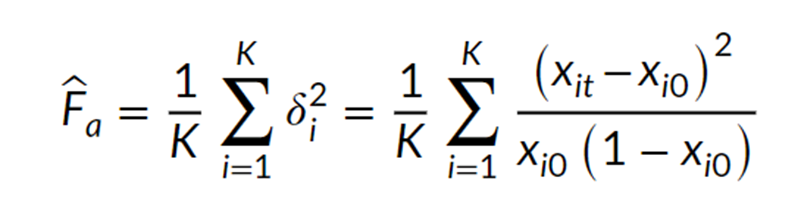



Number of SNPs used to calculate the F statistics:
- 3R_int: 13580
- 3R_4: 5170
- X_int: 4677
- X_4: 1238

In [35]:
# COMPUTE GENOTYPE CALLS FOR THE SNPS

# Visulaised using the scikit-allel wrapper class for genotype calls
gt_2013_3R_int = allel.GenotypeDaskArray(snps_2013_3R_int_unlinked["call_genotype"].data)
gt_2013_3R_4 = allel.GenotypeDaskArray(snps_2013_3R_4_unlinked["call_genotype"].data)
gt_2013_X_int = allel.GenotypeDaskArray(snps_2013_X_int_unlinked["call_genotype"].data)
gt_2013_X_4 = allel.GenotypeDaskArray(snps_2013_X_4_unlinked["call_genotype"].data)

gt_2015_3R_int = allel.GenotypeDaskArray(snps_2015_3R_int_unlinked["call_genotype"].data)
gt_2015_3R_4 = allel.GenotypeDaskArray(snps_2015_3R_4_unlinked["call_genotype"].data)
gt_2015_X_int = allel.GenotypeDaskArray(snps_2015_X_int_unlinked["call_genotype"].data)
gt_2015_X_4 = allel.GenotypeDaskArray(snps_2015_X_4_unlinked["call_genotype"].data)

#gt_2013_3R_int = snps_2013_3R_int_unlinked["call_genotype"].data 
#gt_2013_3R_4 = snps_2013_3R_4_unlinked["call_genotype"].data
#gt_2013_X_int = snps_2013_X_int_unlinked["call_genotype"].data
#gt_2013_X_4 = snps_2013_X_4_unlinked["call_genotype"].data

#gt_2015_3R_int = snps_2015_3R_int_unlinked["call_genotype"].data
#gt_2015_3R_4 = snps_2015_3R_4_unlinked["call_genotype"].data
#gt_2015_X_int = snps_2015_X_int_unlinked["call_genotype"].data
#gt_2015_X_4 = snps_2015_X_4_unlinked["call_genotype"].data

In [36]:
# COMPUTE ALLELE COUNTS

ac_2013_3R_int = gt_2013_3R_int.count_alleles(max_allele=3).compute()
ac_2013_3R_4 = gt_2013_3R_4.count_alleles(max_allele=3).compute()
ac_2013_X_int = gt_2013_X_int.count_alleles(max_allele=3).compute()
ac_2013_X_4 = gt_2013_X_4.count_alleles(max_allele=3).compute()

ac_2015_3R_int = gt_2015_3R_int.count_alleles(max_allele=3).compute()
ac_2015_3R_4 = gt_2015_3R_4.count_alleles(max_allele=3).compute()
ac_2015_X_int = gt_2015_X_int.count_alleles(max_allele=3).compute()
ac_2015_X_4 = gt_2015_X_4.count_alleles(max_allele=3).compute()

In [37]:
# COMPUTE ALLELE FREQUENCIES (Xt and X0)

freq_2013_3R_int = ac_2013_3R_int.to_frequencies()
freq_2013_3R_4 = ac_2013_3R_4.to_frequencies()
freq_2013_X_int = ac_2013_X_int.to_frequencies()
freq_2013_X_4 = ac_2013_X_4.to_frequencies()

freq_2015_3R_int = ac_2015_3R_int.to_frequencies()
freq_2015_3R_4 = ac_2015_3R_4.to_frequencies()
freq_2015_X_int = ac_2015_X_int.to_frequencies()
freq_2015_X_4 = ac_2015_X_4.to_frequencies()

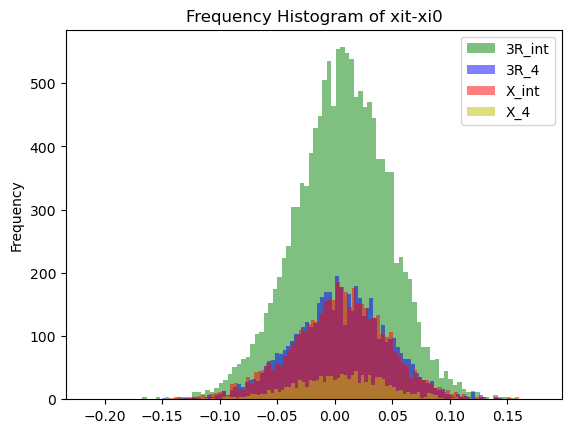

In [38]:
# DISPLAY THE DISTRIBUTION OF XT AND X0

import matplotlib.pyplot as plt

hist_3R_int = []
hist_3R_4 = []
hist_X_int = []
hist_X_4 = []

for i in range(len(freq_2013_3R_int)):
    hist_3R_int.append(max(freq_2015_3R_int[i])-max(freq_2013_3R_int[i]))
    
for i in range(len(freq_2013_3R_4)):
    hist_3R_4.append(max(freq_2015_3R_4[i])-max(freq_2013_3R_4[i]))

for i in range(len(freq_2013_X_int)):
    hist_X_int.append(max(freq_2015_X_int[i])-max(freq_2013_X_int[i]))

for i in range(len(freq_2013_X_4)):
    hist_X_4.append(max(freq_2015_X_4[i])-max(freq_2013_X_4[i]))
    
plt.hist(hist_3R_int, alpha=0.5, bins=100, color='g', label='3R_int')
plt.hist(hist_3R_4, alpha=0.5, bins=100, color='b', label='3R_4')
plt.hist(hist_X_int, alpha=0.5, bins=100, color='r', label='X_int')
plt.hist(hist_X_4, alpha=0.5, bins=100, color='y', label='X_4')

plt.gca().set(title='Frequency Histogram of xit-xi0', ylabel='Frequency')
plt.legend()
plt.show()


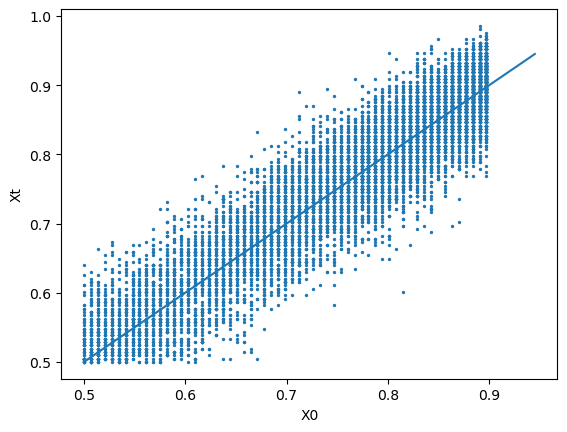

In [39]:
# PLOT XI0 AGAINST XIT

x0 = []
xt = []

for i in range(len(freq_2013_3R_int)):
    x0.append(max(freq_2013_3R_int[i]))
    xt.append(max(freq_2015_3R_int[i]))
    
plt.scatter(x = x0, y= xt, s = 2)
plt.xlabel("X0")
plt.ylabel("Xt")

# Plot y=x line
x = np.linspace(0.5, 0.945, 100)
y = x
plt.plot(x, y, label='y = x')

plt.show()

In [52]:
# CREATE A FUNCTION TO CALCULATE THE Fa STATISTIC

def f_statistic(freq_x0, freq_xt):
    k = len(freq_x0) # Number of SNPs
    # Uses the max values along each row i.e., SNP
    x0 = np.amax(freq_x0, axis=1) 
    xt = np.amax(freq_xt, axis=1)

    # Sum
    f_total = np.sum(((xt-x0)**2)/(x0*(1-x0)))

    f = f_total/k  
    print(f)  
    return f

# Old function - takes longer to run
def f_statistic_original(freq_x0, freq_xt):
    x0 = []
    xt = []
    k = len(freq_x0)
    f_total = 0

    for i in range(k):
        x0.append(max(freq_x0[i]))
        xt.append(max(freq_xt[i]))

    for i in range(k):
        f_total += ((xt[i]-x0[i])**2)/(x0[i]*(1-x0[i]))

    f = f_total/k
#    print(f)   
    return f


In [53]:
# COMPUTE THE Fa-STATISTIC FOR ALL SAMPLES

f_3R_int = f_statistic(freq_2013_3R_int, freq_2015_3R_int)
f_3R_4 = f_statistic(freq_2013_3R_4, freq_2015_3R_4)
f_X_int = f_statistic(freq_2013_X_int, freq_2015_X_int)
f_X_4 = f_statistic(freq_2013_X_4, freq_2015_X_4)


0.010949059991334947
0.010933134981425981
0.011507285658401178
0.010908145353819999


New (MAF>10%):
- 0.010949059991334947
- 0.010933134981425981
- 0.011507285658401178
- 0.010908145353819999

OLD:
- 3R_int: 0.01001658723927551
- 3R_4: 0.010564109499109296
- X_int: 0.01041746932058887
- X_4: 0.009599673323236616

The equation for F-statistic calculated using ratio-of-sums:
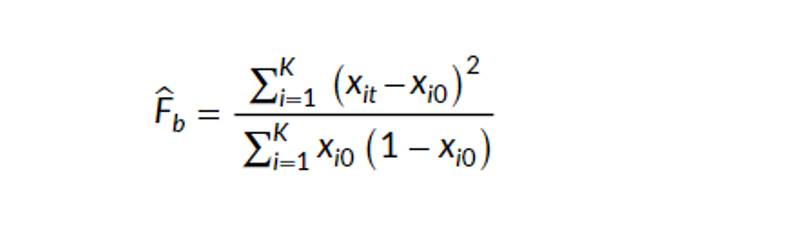

In [47]:
# CREATE A FUNCTION TO CALCUALTE Fb-STATISTIC USING RATIO OF SUMS

def f_statistic_ratio(freq_x0, freq_xt):
    x0 = []
    xt = []
    k = len(freq_x0)
    f_nominator = 0
    f_denominator = 0
    
    for i in range(k):
        x0.append(max(freq_x0[i]))
        xt.append(max(freq_xt[i]))
    
    for i in range(k):
        f_nominator += (xt[i]-x0[i])**2
        f_denominator += x0[i]*(1-x0[i])

    fb = f_nominator/f_denominator
    print(fb)
    
    return fb

In [48]:
# COMPUTE THE Fb-STATISTIC FOR ALL SAMPLES

fb_3R_int = f_statistic_ratio(freq_2013_3R_int, freq_2015_3R_int)
fb_3R_4 = f_statistic_ratio(freq_2013_3R_4, freq_2015_3R_4)
fb_X_int = f_statistic_ratio(freq_2013_X_int, freq_2015_X_int)
fb_X_4 = f_statistic_ratio(freq_2013_X_4, freq_2015_X_4)


0.010798735911679794
0.010764371016122721
0.01134086642068804
0.011035562597602808


### 3.0 Calculating contemporary Ne

Equation to calculate Ne using F-statistic:

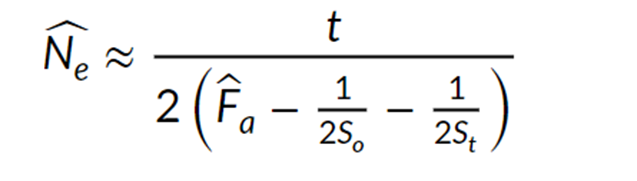

In [49]:
# CALCULATE Fa AFTER REMOVING SAMPLING ERROR FOR EACH

sampling_error_3R_int = f_3R_int - (1/(2*len(snps_2013_3R_int_unlinked.sample_id))) - ((1/(2*len(snps_2015_3R_int_unlinked.sample_id))))
sampling_error_3R_4 = f_3R_4 - (1/(2*len(snps_2013_3R_4_unlinked.sample_id))) - ((1/(2*len(snps_2015_3R_4_unlinked.sample_id))))
sampling_error_X_int = f_X_int - (1/(2*len(snps_2013_X_int_unlinked.sample_id))) - ((1/(2*len(snps_2015_X_int_unlinked.sample_id))))
sampling_error_X_4 = f_X_4 - (1/(2*len(snps_2013_X_4_unlinked.sample_id))) - ((1/(2*len(snps_2015_X_4_unlinked.sample_id))))

print("3R_int:", sampling_error_3R_int)
print("3R_4:", sampling_error_3R_4)
print("X_int:", sampling_error_X_int)
print("X_4:", sampling_error_X_4)

3R_int: -0.0007079473848505113
3R_4: -0.0007238723947594772
X_int: -0.00014972171778428016
X_4: -0.0007488620223654596


In [50]:
# CALCULATE Fb AFTER REMOVING SAMPLING ERROR FOR EACH

sampling_error_3R_int = fb_3R_int - (1/(2*len(snps_2013_3R_int_unlinked.sample_id))) - ((1/(2*len(snps_2015_3R_int_unlinked.sample_id))))
sampling_error_3R_4 = fb_3R_4 - (1/(2*len(snps_2013_3R_4_unlinked.sample_id))) - ((1/(2*len(snps_2015_3R_4_unlinked.sample_id))))
sampling_error_X_int = fb_X_int - (1/(2*len(snps_2013_X_int_unlinked.sample_id))) - ((1/(2*len(snps_2015_X_int_unlinked.sample_id))))
sampling_error_X_4 = fb_X_4 - (1/(2*len(snps_2013_X_4_unlinked.sample_id))) - ((1/(2*len(snps_2015_X_4_unlinked.sample_id))))

print("3R_int:", sampling_error_3R_int)
print("3R_4:", sampling_error_3R_4)
print("X_int:", sampling_error_X_int)
print("X_4:", sampling_error_X_4)

3R_int: -0.0008582714645056638
3R_4: -0.000892636360062737
X_int: -0.0003161409554974185
X_4: -0.0006214447785826503


In [ ]:
# CALCULATE NE

# t: 2 years apart (assumed to correspond to t= 20 generations). - Hui et al., 2022

print(20/(2*-0.00141)) # best not to report negative Ne

### 4. Randomisation test

#### 4.1 Create a function to conduct a randomisation test

Use a randomisation test to plot a distribution of Fa statistics:

1.	Calculate the raw F from your current subset of data. This is your observed F.

2.	Keep using the same subset, shuffle all individuals, assign them randomly into two populations with the same sample sizes. Recalculate the same F. 

3.	Repeat the shuffling for 1000 (say) times, such that 1000 randomised F are obtained. 

4.	Plot a histogram of the 1000 randomised F, then compare to your observed F. 


In [ ]:
# PRINT THE SAMPLE SIZES OF EACH POPULATION

print(len(snps_2013_3R_int_unlinked.sample_id)) #73
print(len(snps_2015_3R_int_unlinked.sample_id)) #104

In [ ]:
# COMBINE THE GENOTYPE CALLS FROM BOTH 2013 AND 2015 AS 1 
gt_2013_3R_int

In [ ]:
gt_2015_3R_int 

All genotype calls have the same number of sites e.g., 13858 for 3R/int but different number of individuals for each combination

In [ ]:
gt_3R_int = allel.GenotypeDaskArray(np.concatenate([gt_2013_3R_int, gt_2015_3R_int], axis=1)) #Joins the dask arrays horizontally i.e., adds columns but same number of rows
gt_3R_4 = allel.GenotypeDaskArray(np.concatenate([gt_2013_3R_4, gt_2015_3R_4], axis=1))
gt_X_int = allel.GenotypeDaskArray(np.concatenate([gt_2013_X_int, gt_2015_X_int], axis=1))
gt_X_4 = allel.GenotypeDaskArray(np.concatenate([gt_2013_X_4, gt_2015_X_4], axis=1))

In [ ]:
gt_3R_int # Has 177 individuals

In [ ]:
gt_3R_int.shape[1]

In [ ]:
# SPLIT THE JOINED DASK ARRAYS INTO TWO - 73 AND 104 INDIVIDUALS IN EACH

# Create an array of a random permutation of the column indicies
split_indices = np.random.permutation(177) # can use gt_3R_int.shape[1] in the brackets but this will be 177 for all
print(split_indices)
print(split_indices[0:73])
print(split_indices[73:177])

In [ ]:
# SPLIT THE DASK ARRAYS
# gt_3R_int[:,0] #rows then columns so this is all rows for the first column

gt_3R_int_73 = gt_3R_int[:,split_indices[0:73]]
gt_3R_int_104 = gt_3R_int[:,split_indices[73:177]]

In [ ]:
gt_3R_int_73

In [ ]:
def randomisation(combined_gt):
    f_statistics = []
    # Repeat for 1000 times
    for i in range(1000):
        # Create an array of a random permutation of the column indicies
        split_indices = np.random.permutation(177) # can use gt_3R_int.shape[1] in the brackets but this will be 177 for all
        gt_73 = combined_gt[:,split_indices[0:73]]
        gt_104 = combined_gt[:,split_indices[73:177]]
        # Compute allele counts
        ac_73  = gt_73 .count_alleles(max_allele=3).compute()
        ac_104 = gt_104.count_alleles(max_allele=3).compute()
        # Compute allele frequencies
        freq_73 = ac_73.to_frequencies()
        freq_104 = ac_104.to_frequencies()
        # Calculate and append fa statistic using function
        f_statistics.append(f_statistic(freq_2013_3R_int, freq_2015_3R_int))
    return f_statistics  

In [ ]:
random_f_3R_int = randomisation(gt_3R_int)
print("Done gt_3R_int")
random_f_3R_4 = randomisation(gt_3R_4)
print("Done gt_3R_4")
random_f_X_int = randomisation(gt_X_int)
print("Done gt_X_int")
random_f_X_4 = randomisation(gt_X_4)
print("Done gt_X_4")

In [ ]:
# EXPORT THE RESULTS 

#with open('random_f_3R_int.pkl', 'wb') as f:
#    pickle.dump(random_f_3R_int, f)
    
#with open('random_f_3R_4.pkl', 'wb') as f:
#    pickle.dump(random_f_3R_4, f)
    
#with open('random_f_X_int.pkl', 'wb') as f:
#    pickle.dump(random_f_X_int, f)
    
#with open('random_f_X_4.pkl', 'wb') as f:
#    pickle.dump(random_f_X_4, f)

In [ ]:
# IMPORT THE RESULTS 

with open('random_f_3R_int.pkl', 'rb') as f:
    random_f_3R_int = pickle.load(f)
    
with open('random_f_3R_4.pkl', 'rb') as f:
    random_f_3R_4 = pickle.load(f)
    
with open('random_f_X_int.pkl', 'rb') as f:
    random_f_X_int = pickle.load(f)
    
with open('random_f_X_4.pkl', 'rb') as f:
    random_f_X_4 = pickle.load(f)

In [ ]:
random_f_3R_int

In [ ]:
random_f_3R_int_no_inf = random_f_3R_int.copy()

In [ ]:
random_f_3R_int_no_inf

In [ ]:
max(random_f_3R_int) #3R_int max is infinity but others are not

In [ ]:
random_f_3R_int_no_inf.remove(np.inf)
random_f_3R_int_no_inf

NOTE: The randomisation test functions took too long to run 1000 times on here. Alternatively, pre-written code in R found on FYP - (3.1) randomisation_F_R was used instead to obtain the null Fa.

#### 4.2 Plot histograms of the randomisation results

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

# Original F values
observed_F = [0.01001658723927551, 0.010564109499109296, 0.01041746932058887, 0.009599673323236616]

# Plot the histograms
axes[0, 0].hist(random_f_3R_int_no_inf, bins=40, color='blue', alpha=0.5)
axes[0, 0].axvline(x=observed_F[0] ,color='black', linestyle='--', linewidth=1)
axes[0, 0].set_title('3R_int')

axes[0, 1].hist(random_f_3R_4, bins=40, color='red', alpha=0.5)
axes[0, 1].axvline(x=observed_F[1] ,color='black', linestyle='--', linewidth=1)
axes[0, 1].set_title('3R_4')

axes[1, 0].hist(random_f_X_int, bins=40, color='green', alpha=0.5)
axes[1, 0].axvline(x=observed_F[2] ,color='black', linestyle='--', linewidth=1)
axes[1, 0].set_title('X_int')

axes[1, 1].hist(random_f_X_4, bins=40, color='purple', alpha=0.5)
axes[1, 1].axvline(x=observed_F[3] ,color='black', linestyle='--', linewidth=1)
axes[1, 1].set_title('X_4')

plt.show()

New (MAF>10%) calculated in Python:
- 0.010949059991334947
- 0.010933134981425981
- 0.011507285658401178
- 0.010908145353819999

I'm not sure why but Fa calculated in R and above is slightly different.

#### 4.3 Re-plot randomisation test (using the F-statistics calculated in R)

Fa:
- X_4: 0.0111445581858069
- X_int: 0.0118885280123931 (positive Fa after sampling! But, within the distribution?)
- 3R_int: 0.0112564541599081 (Fa outside of null_Fa distribution and has inf values in null_Fa)
- 3R_4: 0.0112449825807431

In [9]:
# IMPORT FILES

null_Fa_3R_int = np.loadtxt('null_Fa_3R_int_10.txt') #Has inf values
null_Fa_3R_4 = np.loadtxt('null_Fa_3R_4_10.txt')
null_Fa_X_4 = np.loadtxt('null_Fa_X_4_10.txt')
null_Fa_X_int = np.loadtxt('null_Fa_X_int_10.txt') 

In [10]:
# REMOVE INFINITY VALUES FROM THE NULL FA

# Why is there inf values when the allele frequencies are finite?

# Make a copy of the list
null_Fa_3R_int_no_inf = null_Fa_3R_int.copy().tolist()
null_Fa_3R_4_no_inf = null_Fa_3R_4.copy().tolist()
null_Fa_X_int_no_inf = null_Fa_X_int.copy().tolist()
null_Fa_X_4_no_inf = null_Fa_X_4.copy().tolist()

In [11]:
# Remove inf from the copied lists

null_Fa_3R_int_no_inf = [value for value in null_Fa_3R_int_no_inf if value != np.inf]
null_Fa_3R_4_no_inf = [value for value in null_Fa_3R_4_no_inf if value != np.inf]
null_Fa_X_int_no_inf = [value for value in null_Fa_X_int_no_inf if value != np.inf]
null_Fa_X_4_no_inf = [value for value in null_Fa_X_4_no_inf if value != np.inf]

In [12]:
max(null_Fa_3R_int_no_inf)

0.0127749861299823

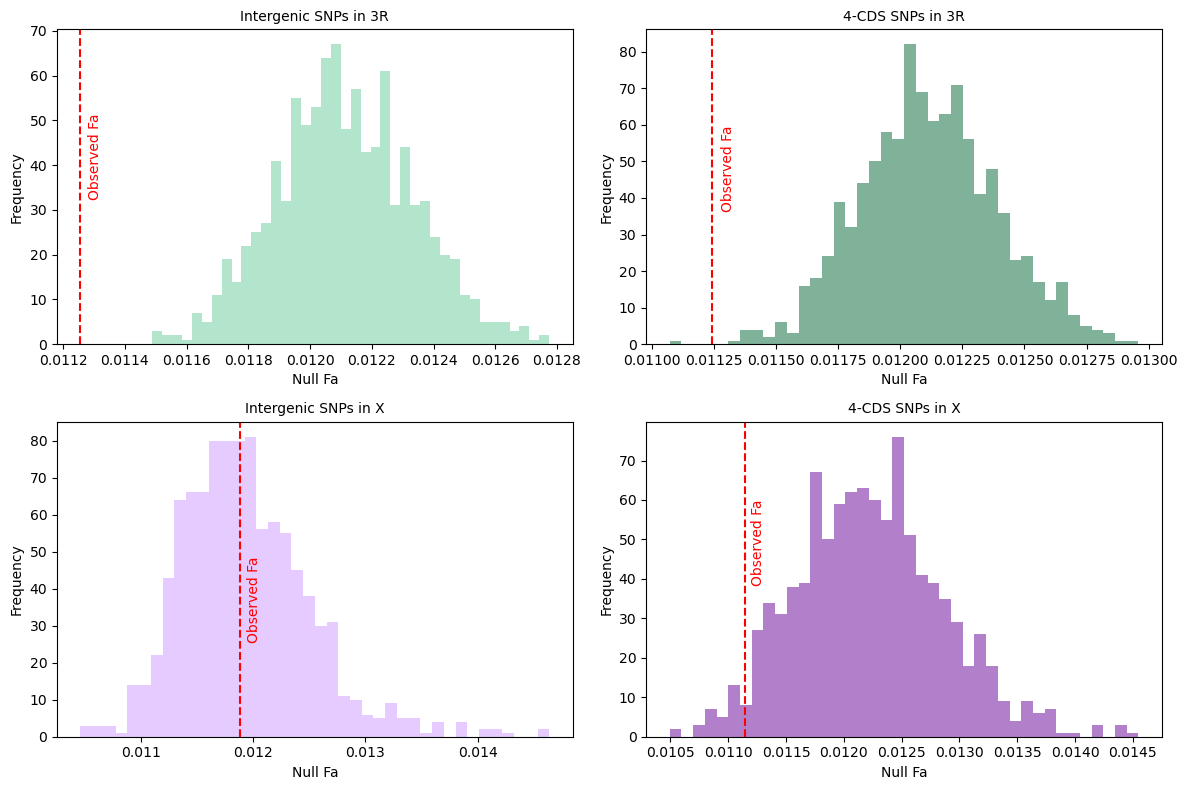

In [13]:
# OBSERVED Fa

Fa_3R_4 = 0.0112449825807431  
Fa_3R_int = 0.0112564541599081 
Fa_X_int = 0.0118885280123931 
Fa_X_4 = 0.0111445581858069


# Plot the histograms
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

axes[0, 0].hist(null_Fa_3R_int_no_inf, bins=40, color='#66CC99', alpha=0.5)
axes[0, 0].axvline(x=Fa_3R_int, color='red', linestyle='--', linewidth=1.5, label = "Observed Fa")
axes[0, 0].set_title('Intergenic SNPs in 3R',fontsize=10)

axes[0, 1].hist(null_Fa_3R_4_no_inf, bins=40, color='#006633', alpha=0.5)
axes[0, 1].axvline(x=Fa_3R_4, color='red', linestyle='--', linewidth=1.5, label = "Observed Fa")
axes[0, 1].set_title('4-CDS SNPs in 3R',fontsize=10)

axes[1, 0].hist(null_Fa_X_int_no_inf, bins=40, color='#CC99FF', alpha=0.5)
axes[1, 0].axvline(x=Fa_X_int, color='red', linestyle='--', linewidth=1.5 ,label = "Observed Fa")
axes[1, 0].set_title('Intergenic SNPs in X',fontsize=10)

axes[1, 1].hist(null_Fa_X_4_no_inf, bins=40, color='#660099', alpha=0.5)
axes[1, 1].axvline(x=Fa_X_4, color='red', linestyle='--', linewidth=1.5, label = "Observed Fa")
axes[1, 1].set_title('4-CDS SNPs in X',fontsize=10)


axes[0,0].set_ylabel("Frequency")
axes[1,0].set_ylabel("Frequency")
axes[1,1].set_ylabel("Frequency")
axes[0,1].set_ylabel("Frequency")

axes[0,0].set_xlabel("Null Fa")
axes[1,0].set_xlabel("Null Fa")
axes[1,1].set_xlabel("Null Fa")
axes[0,1].set_xlabel("Null Fa")

#axes[0,0].legend()  # I think rather than legend, it migth be better to include text (vertically on line)
#axes[0,1].legend()
#axes[1,1].legend()
#axes[1,0].legend()

# Add text
axes[0,0].text(0.01128, 33 , 'Observed Fa', rotation='vertical', color = "red")
axes[0,1].text(0.01128, 37 , 'Observed Fa', rotation='vertical', color = "red")
axes[1,0].text(0.01195, 26 , 'Observed Fa', rotation='vertical', color = "red")
axes[1,1].text(0.0112, 39 , 'Observed Fa', rotation='vertical', color = "red")

plt.tight_layout()

# Save the figure as png
#plt.savefig('randomisation_F_10.png')

plt.show()

Equation to calculate Ne using F-statistic:

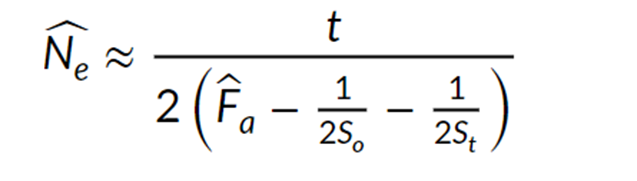

In [40]:
# CALCULATE Fa AFTER REMOVING SAMPLING ERROR FOR EACH

sampling_error_3R_int = Fa_3R_int - (1/(2*73)) - ((1/(2*104)))
sampling_error_3R_4 = Fa_3R_4 - (1/(2*73)) - ((1/(2*104)))
sampling_error_X_int = Fa_X_int - (1/(2*73)) - ((1/(2*104)))
sampling_error_X_4 = Fa_X_4 - (1/(2*73)) - ((1/(2*104)))

print("3R_int:", format(sampling_error_3R_int, '.6f'))
print("3R_4:", format(sampling_error_3R_4, '.6f'))
print("X_int:", format(sampling_error_X_int, '.6f'))
print("X_4:", format(sampling_error_X_4, '.6f'))

3R_int: -0.000401
3R_4: -0.000412
X_int: 0.000232
X_4: -0.000512


In [36]:
# CALCULATE NE
# t: 2 years apart (assumed to correspond to t= 20 generations). - Hui et al., 2022

print(20/(2*sampling_error_X_int))  # 43192.69402417944


43192.69402417944


### 5.Confidence interval

NOTE: The code for the CI was not written by me but by my supervisor Tin-Yu Hui. It can be found in FYP - (3.2) CI_F (with Fa).

Fa:
- X_4: 0.0111445581858069
- X_int: 0.0118885280123931 (positive Fa after sampling! But, within the distribution?)
- 3R_int: 0.0112564541599081 (Fa outside of null_Fa distribution and has inf values in null_Fa)
- 3R_4: 0.0112449825807431

In [37]:
# Raw Fa
print("X_4:", format(0.0111445581858069, '.6f'))
print("X_int:", format(0.0118885280123931 , '.6f'))
print("3R_int:", format(0.0112564541599081 , '.6f'))
print("3R_4:", format(0.0112449825807431 , '.6f'))

X_4: 0.011145
X_int: 0.011889
3R_int: 0.011256
3R_4: 0.011245


In [43]:
# Fa after sampling error
print("X_4:", format(sampling_error_X_4, '.6f'))
print("X_int:", format(sampling_error_X_int, '.6f'))
print("3R_int:", format(sampling_error_3R_int, '.6f'))
print("3R_4:", format(sampling_error_3R_4, '.6f'))

X_4: -0.000512
X_int: 0.000232
3R_int: -0.000401
3R_4: -0.000412


In [44]:
from platform import python_version

print(python_version())

# 3.9.13

3.9.13
